# MLP를 이용한 MNIST 인식
- Universal Approximatiom Theorem
 - MLP로 임의의 함수를 모델링할 수 있다는 이론
 - 학습 데이터가 충분하다는 가정이 필요함
- [MNIST 데이터 보기](https://www.researchgate.net/figure/Example-images-from-the-MNIST-dataset_fig1_306056875)
- Dropout, ReLU 활성화 함수 사용
- 배치 정규화
 - 계층마다 입력의 분포가 달라짐으로써 학습속도가 느려지는 현상(Internal Covariance Shift)를 줄이는 방법
 - 계층의 입력 분포를 정규화 하여 학습속도를 개선한다
 - ReLU 활성화 함수가 제대로, 의미있게 동작하려면 입력의 분포를 정규화 해야 한다
 - He 정규화를 사용하겠다

# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F  # 자주 이용되는 함수 모듈
# 컴퓨터 비전에서 자주사용되는 모듈
from torchvision import transforms, datasets

In [2]:
# 사용장비가 cpu인지 gpu인지 확인 (런타임 - 런타임 유형변경에서 확인)
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.0  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 5

# 데이터 다운로드 (훈련/검증 데이터)

- DataLoader 함수를 사용하여 미니배치 크기로 데이터를 준비한다


In [4]:
train_dataset = datasets.MNIST(root = "../data/MNIST",  # 데이터 저장 폴더 지정
                               train = True,            # 학습용 데이터인지를 구분 (검증용이면 False)
                               download = True,         # 데이터 다운로드를 수행
                               transform = transforms.ToTensor()) # 이미지 데이터를 전처리하여 (0~1) 범위의 텐서로 변경

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,            # 학습에 사용하지 않는 것을 표시
                              transform = transforms.ToTensor())
# 미니 배치 크기로 묶어서 저장한다
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE, 
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 데이터 확인하기
- 데이터 구조 보기
- (batch, feature, shape)

In [17]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


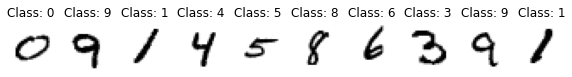

In [11]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

# MLP 모델 구성

- nn.Module을 상속하는 클래스 Net을 정의한다
- __init__ 함수는 객체 생성시의 동작을 지정한다 (생성자 호출시 수행하는 내용)

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()         # "조상인" nn.Module에 정의된 기본 메소드를 상속받아 수행한다
        self.fc1 = nn.Linear(28 * 28, 512)  # 입력단 전결합망을 만드고 입력과 출력의 크기를 정해준다
        self.fc2 = nn.Linear(512, 256)      # 두번째 전결합망 정의
        self.fc3 = nn.Linear(256, 10)       # 출력단 정의
        self.dropout_prob = 0.5             # 드롭아웃 비율을 50%로 설정
        self.batch_norm1 = nn.BatchNorm1d(512) # 첫번째 배치 정규화 정의
        self.batch_norm2 = nn.BatchNorm1d(256) # 두번째 배치 정규화 정의

    def forward(self, x):                   # 순방향 작업을 정의
        x = x.view(-1, 28 * 28)             # 1차원 어레이, 즉 벡터로 변환하는 작업 (Faltted 작업)
        x = self.fc1(x)                     # init()에 정의도 fc1을 통과시킨다
        x = self.batch_norm1(x)             # 배치 정규화
        x = F.relu(x)                       # 활성화 함수 적용
                                            # 드롭아웃은 학습과정에서만 수행한다
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)        # 로그 소프트맥스를 수행
        return x                             # 함수 수행 결과 값

## 모델 환경 설정
- 가중치 호기화
- 최적화기 선택 (Adam)
- 손실함수 정의 (크로스엔트로피)

In [19]:
# 모델 환경 설정
import torch.nn.init as init  # 초기값 설정용 모듈
def weight_init(m):           # 가중치 초기화 함수 정의   
    if isinstance(m, nn.Linear): # nn.Linear에 해당하는 경우만 처리
        init.kaiming_uniform_(m.weight.data) # He 초기화 적용

model = Net().to(DEVICE)      # 모델을 특정 디바이스에 할당
model.apply(weight_init)      # 모델에 위에서 정의한 가중치 초기화 함수를 적용
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()  # 분류의 손실함수로 크로스엔트로피를 사용

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## 학습
- train_loader에는 배치 단위로 이미지와 레이블이 들어 있다

In [20]:
# MLP 모델 학습 및 성능 확인 함수 정의
def train(model, train_loader, optimizer, log_interval):
    model.train()                # 모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader): # 미니 배치 단위로 처리
        image = image.to(DEVICE) # 이미지를 디바이스에 할당
        label = label.to(DEVICE) # 레이블을 디바이스에 할당
        optimizer.zero_grad()    # 미니 배치 단위로 그라디언트를 초기화
        output = model(image)    # 이미지를 모델에 입력
        loss = criterion(output, label) # 손실 함수 (크로스엔트로피) 계산
        loss.backward()          # 손실함수를 바탕으로 역전파를 통해 그라디언트를 전파
        optimizer.step()         # 파라미터 값을 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

## 성능 평가

In [21]:
# 검증 데이터에 대한 모델 성능확인 함수 정의
def evaluate(model, test_loader):
    model.eval()          # 학습이 완료된 모델을 학습상태가 아닌 평가 상태로 설정
    test_loss = 0         # test_loader 내의 데이터로 새로운 손실값을 구하기 위해 초기화
    correct = 0           # 맞춘 분류의 수를 세기 위해서 초기화

    with torch.no_grad(): # 모델 평가시에는 학습을 중지해야 하므로 그라디언트의 흐름을 막는다
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()  # 크로스 엔트로피, 손실함수 계산
            prediction = output.max(1, keepdim = True)[1] # 확률이 최대치인 위치 찾기
            correct += prediction.eq(label.view_as(prediction)).sum().item()
                                                          # 예측이 레이블과 같으면 correct 증가
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)  # 손실함수의 평균값 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) # 정확도 계산
    return test_loss, test_accuracy

# 훈련 및 검증

In [22]:
# 훈련 및 검증
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 3.221599
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.538131
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.098416
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.404739
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.449803
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.270219
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.150892
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.271450
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.547904
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.303052

[EPOCH: 1], 	Test Loss: 0.1245, 	Test Accuracy: 96.07 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.208395
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.338001
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.273461
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.128576
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.544601
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.474151
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.149927
T